In [1]:
# Voeg src/ toe aan importpad
import sys
from pathlib import Path
project_root = Path.cwd().parent if Path.cwd().name == "tests" else Path.cwd()
src_path = project_root / "src"
if src_path.exists() and str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
import numpy as np
import sqlite3

from models.naive_model import run_naive_model, evaluate_rmse
from models.sarimax_model import run_sarimax

In [2]:
# DB connectie en master_warp inladen
db_path = project_root / "src" / "data" / "WARP.db"
conn = sqlite3.connect(db_path)
df = pd.read_sql("SELECT * FROM master_warp", conn)
conn.close()

# Zet datetime index
df["target_datetime"] = pd.to_datetime(df["target_datetime"], utc=True)
df = df.sort_values("target_datetime").set_index("target_datetime")

# Targets en features
target_col = "Price"
feature_cols = ["Total_Flow", "temperature_2m", "Solar_Vol"]
horizon = 168

# Opschonen en splitsen
y = df[target_col].dropna()
y = y[~y.index.duplicated()]
X = df[feature_cols].loc[y.index].dropna()

In [3]:
# 📅 Handmatige datums instellen
train_start = pd.Timestamp("2025-03-25 00:00:00", tz="UTC")
train_end = pd.Timestamp("2025-04-21 23:00:00", tz="UTC")

# Horizon (7 dagen vooruit)
fh_start = train_end + pd.Timedelta(hours=1)
fh = pd.date_range(start=fh_start, periods=horizon, freq="h")

# SARIMAX splits
y_train_sarimax = y.loc[train_start:train_end]
X_train_sarimax = X.loc[train_start:train_end]
X_test_sarimax = X.loc[fh]

# Naive splits
y_train_naive = y.loc[train_end - pd.Timedelta(hours=168):train_end]
y_test = y.loc[fh_start:fh_start + pd.Timedelta(hours=horizon - 1)]

In [4]:
# Placeholder: hier kun je rolling, lags, scaling toevoegen
# Voor SARIMAX voorlopig niet nodig
# Voor XGBoost etc. later hier uitbreiden
pass

2025-05-16 09:26:46,903 - sarimax - INFO - 📈 Fitting SARIMAX with order=(1, 1, 1), seasonal_order=(1, 1, 1, 24)
/Users/redouan/.pyenv/versions/3.10.13/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/redouan/.pyenv/versions/3.10.13/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/redouan/.pyenv/versions/3.10.13/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
2025-05-16 09:26:51,390 - sarimax - INFO - 📊 RMSE: 0.02
2025-05-16 09:26:51,396 - sarimax - INFO - 📈 Fitting SARIMAX with order=(1, 1, 1), seasonal_order=(1, 1, 1, 24)
/Users/red

🟡 Naive RMSE:          0.03
🔵 SARIMAX (no exog):   0.02
🔵 SARIMAX (with exog): 23365609492.26


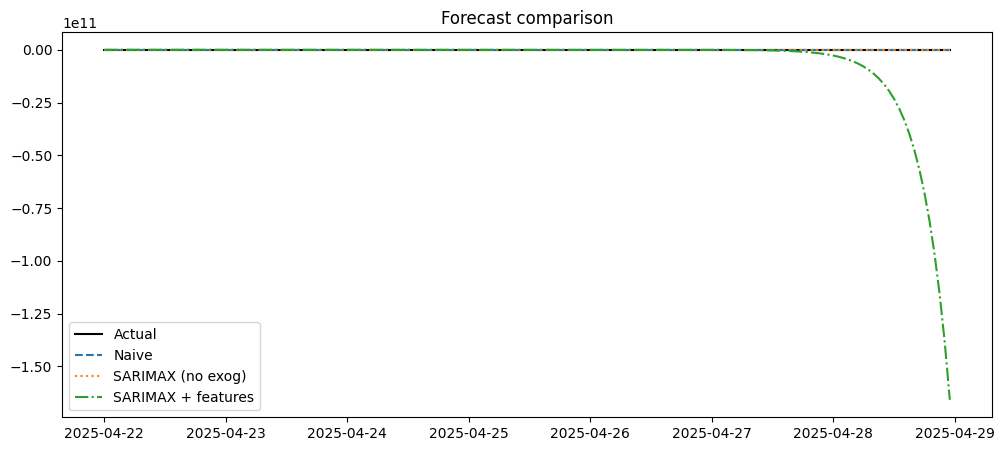

In [5]:
# ------------------------------
# 🟡 Naive model
# ------------------------------
naive_preds = run_naive_model(y, lag=horizon).loc[fh]
rmse_naive = root_mean_squared_error(y.loc[fh], naive_preds)

# ------------------------------
# 🔵 SARIMAX zonder features
# ------------------------------
sarimax_preds_nofeatures, rmse_sarimax_nf = run_sarimax(
    y_train_sarimax,
    X_train=None,
    X_test=pd.DataFrame(index=fh),
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 24)
)

# ------------------------------
# 🔵 SARIMAX met exogene features
# ------------------------------
sarimax_preds_with_features, rmse_sarimax_feat = run_sarimax(
    y_train_sarimax,
    X_train_sarimax,
    X_test_sarimax,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 24)
)

# ------------------------------
# 📊 Toon resultaten
# ------------------------------
print(f"🟡 Naive RMSE:          {rmse_naive:.2f}")
print(f"🔵 SARIMAX (no exog):   {rmse_sarimax_nf:.2f}" if rmse_sarimax_nf is not None else "🔵 SARIMAX (no exog):   skipped")
print(f"🔵 SARIMAX (with exog): {rmse_sarimax_feat:.2f}" if rmse_sarimax_feat is not None else "🔵 SARIMAX (with exog): skipped")

# ------------------------------
# 📈 Plot resultaten
# ------------------------------
plt.figure(figsize=(12, 5))
plt.plot(y.loc[fh].index, y.loc[fh].values, label="Actual", color="black")
plt.plot(naive_preds.index, naive_preds.values, label="Naive", linestyle="--")

if sarimax_preds_nofeatures is not None:
    plt.plot(fh, sarimax_preds_nofeatures, label="SARIMAX (no exog)", linestyle=":")

if sarimax_preds_with_features is not None:
    plt.plot(fh, sarimax_preds_with_features, label="SARIMAX + features", linestyle="-.")

plt.legend()
plt.title("Forecast comparison")
plt.show()

In [6]:
loop_days = 10
results = []

for i in range(loop_days):
    delta = pd.Timedelta(days=i)
    
    t_start = train_start + delta
    t_end = train_end + delta
    fh_start = t_end + pd.Timedelta(hours=1)
    fh = pd.date_range(start=fh_start, periods=horizon, freq="h")
    
    try:
        y_train_naive = y.loc[t_end - pd.Timedelta(hours=167):t_end]
        y_test = y.loc[fh_start:fh_start + pd.Timedelta(hours=horizon - 1)]

        naive_preds = run_naive_model(y_train_naive)
        rmse_naive = mean_squared_error(y_test, naive_preds, squared=False)

        y_train_sarimax = y.loc[t_start:t_end]
        X_train_sarimax = X.loc[t_start:t_end]
        X_test_sarimax = X.loc[fh]

        sarimax_preds = run_sarimax(y_train_sarimax, X_train_sarimax, X_test_sarimax, order=(1,1,1), seasonal_order=(1,1,1,24))
        rmse_sarimax = mean_squared_error(y.loc[fh], sarimax_preds, squared=False)

        results.append({
            "start": str(t_start.date()),
            "end": str(t_end.date()),
            "rmse_naive": rmse_naive,
            "rmse_sarimax": rmse_sarimax
        })

    except Exception as e:
        print(f"⚠️ Iteratie {i} overgeslagen: {e}")

# Resultaten tonen
df_results = pd.DataFrame(results)
display(df_results)

⚠️ Iteratie 0 overgeslagen: Test set is too small for lag 168. Minimum required rows: 169, found: 168
⚠️ Iteratie 1 overgeslagen: Test set is too small for lag 168. Minimum required rows: 169, found: 168
⚠️ Iteratie 2 overgeslagen: Test set is too small for lag 168. Minimum required rows: 169, found: 168
⚠️ Iteratie 3 overgeslagen: Test set is too small for lag 168. Minimum required rows: 169, found: 168
⚠️ Iteratie 4 overgeslagen: Test set is too small for lag 168. Minimum required rows: 169, found: 168
⚠️ Iteratie 5 overgeslagen: Test set is too small for lag 168. Minimum required rows: 169, found: 168
⚠️ Iteratie 6 overgeslagen: Test set is too small for lag 168. Minimum required rows: 169, found: 168
⚠️ Iteratie 7 overgeslagen: Test set is too small for lag 168. Minimum required rows: 169, found: 168
⚠️ Iteratie 8 overgeslagen: Test set is too small for lag 168. Minimum required rows: 169, found: 168
⚠️ Iteratie 9 overgeslagen: Test set is too small for lag 168. Minimum required ro

""
